# Wine Rating Data Exploration

With these next steps we will explore the dataset at hand, converting the columns for better input the dataset into predictive algorithms.
The dataset has been split 70-30 instead of the original 90-10 in order to better control variance in performance measures (given the relatively small dataset available for the challenge).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import re
import scipy
import numpy as np
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import category_encoders as ce

Train and test set are combined for data analysis.

Since this is a sample dataset, all the operations on categorical data must take into account additional possible values.

In [2]:
df = pd.read_csv('../data_root/split/train.csv')

In [3]:
df.sample(10)  # [['title', 'designation', 'description', 'variety']]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
2117,Argentina,"Shy aromas of green banana, lime and lychee se...",Finca Los Primos,86,12.0,Mendoza Province,NaN,NaN,Michael Schachner,@wineschach,Valentin Bianchi 2015 Finca Los Primos Torrontés,Torrontés,Valentin Bianchi
5934,US,Camiana has been establishing a real track rec...,Blue Hall Vineyard,93,75.0,California,Howell Mountain,Napa,NaN,NaN,Camiana 2008 Blue Hall Vineyard Cabernet Sauvi...,Cabernet Sauvignon,Camiana
6493,US,"Just what a Dry Creek Zin should be. It's dry,...",Voigt Family Vineyards,88,24.0,California,Dry Creek Valley,Sonoma,NaN,NaN,J. Rickards 2010 Voigt Family Vineyards Zinfan...,Zinfandel,J. Rickards
5479,US,"Leather, black pepper and fresh compost shock ...",NaN,90,38.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Robert Foley 2014 Charbono (Napa Valley),Charbono,Robert Foley
5698,US,You might want to lay this Syrah-based Rhône w...,MJM,89,50.0,California,California,California Other,NaN,NaN,Dragonette 2007 MJM Red (California),Rhône-style Red Blend,Dragonette
892,Portugal,This finely wood-aged wine is rich and packed ...,Reserva,90,28.0,Dão,NaN,NaN,Roger Voss,@vossroger,Vinha Paz 2015 Reserva White (Dão),Portuguese White,Vinha Paz
5913,New Zealand,"Made in a clean, refreshing style, this is a m...",NaN,89,21.0,Marlborough,NaN,NaN,Joe Czerwinski,@JoeCz,Wairau River 2014 Pinot Gris (Marlborough),Pinot Gris,Wairau River
190,France,"A perfumed wine with red fruits, this offers d...",Les Grèves Premier Cru,93,100.0,Burgundy,Beaune,NaN,Roger Voss,@vossroger,Tollot Beaut et Fils 2014 Les Grèves Premier C...,Pinot Noir,Tollot Beaut et Fils
2679,US,"Fresh dill, dewy herbs and a seared lemon-syru...",NaN,91,28.0,California,Santa Cruz Mountains,Central Coast,Matt Kettmann,@mattkettmann,Sarah's Vineyard 2013 Chardonnay (Santa Cruz M...,Chardonnay,Sarah's Vineyard
114,US,"Dark, bone dry and tannic, a full-bodied wine ...",NaN,87,12.0,California,Central Coast,Central Coast,NaN,NaN,Estancia 2007 Shiraz (Central Coast),Shiraz,Estancia


## Data processing
We will process data with 2 goals in mind:
* keep the cardinality under control
* substitute the missing values with most coherent ones

### Missing Values and Cardinalities

From looking at some random points from the dataset, we can see that it contains missing values. 
We want to have an idea on how many are missing:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7953 entries, 0 to 7952
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                7947 non-null   object 
 1   description            7953 non-null   object 
 2   designation            5699 non-null   object 
 3   points                 7953 non-null   int64  
 4   price                  7403 non-null   float64
 5   province               7947 non-null   object 
 6   region_1               6615 non-null   object 
 7   region_2               3069 non-null   object 
 8   taster_name            6350 non-null   object 
 9   taster_twitter_handle  6064 non-null   object 
 10  title                  7953 non-null   object 
 11  variety                7953 non-null   object 
 12  winery                 7953 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 807.9+ KB


In [5]:
df.isnull().sum().sort_values()

description                 0
points                      0
title                       0
variety                     0
winery                      0
country                     6
province                    6
price                     550
region_1                 1338
taster_name              1603
taster_twitter_handle    1889
designation              2254
region_2                 4884
dtype: int64

Luckily all the values in the target column for this task (`points`) are non-empty, so we don't have to discard any row. Also `title`, `description`, `variety` and `winery` don't have any missing value. We will explore the other variables to find ways to populate the missing values. If it is not possible to do that in a meaningful way, the variables will just be discarded.

We then check the cardinality of each of the variables at hand, and decide what to do with variables that have too many possible variable, which would make the training of a model unstable and unreliable.

In [6]:
object_columns = df.select_dtypes(include="object").columns

for column in object_columns:
    print(f"Variable '{column}' has cardinality {df[column].nunique()}")

Variable 'country' has cardinality 35
Variable 'description' has cardinality 7953
Variable 'designation' has cardinality 4417
Variable 'province' has cardinality 231
Variable 'region_1' has cardinality 685
Variable 'region_2' has cardinality 17
Variable 'taster_name' has cardinality 18
Variable 'taster_twitter_handle' has cardinality 14
Variable 'title' has cardinality 7943
Variable 'variety' has cardinality 300
Variable 'winery' has cardinality 4700


### Reducing number of possible values for high cardinality variables

Variables `description`, `designation`, `title` and `winery` have a very high cardinality, and must be reduced. Otherwise the number of feature used to train the model will be higher than the number of points, resulting in unstable predictions.

We see that title in many cases contains the year of the wine. We can extract that to transform a categorical variable in an easier to use integer numerical one.

In [7]:
years = [float('nan') for _ in range(len(df['title']))]
for i, title in enumerate(df['title']):
    # Find 4 consecutive digits in the title's text
    matched_years = re.findall(r"\d{4}", title)
    for year in matched_years:
        # Only use numbers that might actually be wine years
        if year[:2] in ['18', '19', '20']: 
            years[i] = int(year)
        
df['year'] = years

In order to decrease the cardinality of the description variable, the tf-idf algorithm was used to extract the 100 most important important words to a description in the collection of all reviews.

In [8]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,1), lowercase=True, max_features=100)
description_features = vectorizer.fit_transform(df['description'])
print(vectorizer.get_feature_names())

dense_features = pd.DataFrame(description_features.toarray())
dense_features.columns = [f"desc_{name}" for name in vectorizer.get_feature_names()]
df = pd.concat([df, dense_features], axis=1)
print(df.info())
print(df.isnull().sum().sort_values())

['acidity', 'age', 'aging', 'alongside', 'apple', 'aromas', 'balance', 'balanced', 'berry', 'bit', 'black', 'blackberry', 'blend', 'bodied', 'bright', 'cabernet', 'character', 'cherry', 'chocolate', 'citrus', 'clean', 'concentrated', 'creamy', 'crisp', 'currant', 'dark', 'dried', 'drink', 'dry', 'earthy', 'elegant', 'fine', 'finish', 'firm', 'flavor', 'flavors', 'fresh', 'fruit', 'fruits', 'fruity', 'good', 'green', 'herb', 'herbal', 'hint', 'juicy', 'just', 'lead', 'lemon', 'licorice', 'light', 'like', 'lime', 'long', 'medium', 'merlot', 'mineral', 'mouth', 'nose', 'note', 'notes', 'oak', 'offers', 'opens', 'orange', 'palate', 'peach', 'pear', 'pepper', 'pinot', 'plum', 'raspberry', 'ready', 'red', 'rich', 'ripe', 'sauvignon', 'shows', 'smooth', 'soft', 'spice', 'spicy', 'structure', 'structured', 'style', 'sweet', 'syrah', 'tannic', 'tannins', 'tart', 'texture', 'toast', 'tobacco', 'touch', 'vanilla', 'vineyard', 'white', 'wine', 'wood', 'years']
<class 'pandas.core.frame.DataFrame'>

It looks like `taster_name` and `taster_twitter_handle` are collinear variables.
In order to check if that is true, we count how many taster twitter are linked to each taster name, and vice versa:

In [9]:
tasters_twitter: dict = {}
twitters_taster: dict = {}
    
for name, twitter in zip(df["taster_name"], df["taster_twitter_handle"]):
    # Create a dict with a set containing all the twitter accounts connected to a name
    if not tasters_twitter.get(name):
        tasters_twitter[name] = {twitter}
    else:
        tasters_twitter[name].add(twitter)
    # Create a dict with a set containing all the names connected to a twitter account
    if not twitters_taster.get(twitter):
        twitters_taster[twitter] = {name}
    else:
        twitters_taster[twitter].add(name)

print("Twitter accounts connected to each taster")
pprint(tasters_twitter)
print("\nTaster names connected to each twitter account")
pprint(twitters_taster)

Twitter accounts connected to each taster
{nan: {nan},
 'Alexander Peartree': {nan},
 'Anna Lee C. Iijima': {nan},
 'Anne Krebiehl\xa0MW': {'@AnneInVino'},
 'Carrie Dykes': {nan},
 'Fiona Adams': {'@bkfiona'},
 'Jeff Jenssen': {'@worldwineguys'},
 'Jim Gordon': {'@gordone_cellars'},
 'Joe Czerwinski': {'@JoeCz'},
 'Kerin O’Keefe': {'@kerinokeefe'},
 'Lauren Buzzeo': {'@laurbuzz'},
 'Matt Kettmann': {'@mattkettmann'},
 'Michael Schachner': {'@wineschach'},
 'Mike DeSimone': {'@worldwineguys'},
 'Paul Gregutt': {'@paulgwine\xa0'},
 'Roger Voss': {'@vossroger'},
 'Sean P. Sullivan': {'@wawinereport'},
 'Susan Kostrzewa': {'@suskostrzewa'},
 'Virginie Boone': {'@vboone'}}

Taster names connected to each twitter account
{nan: {'Alexander Peartree', nan, 'Carrie Dykes', 'Anna Lee C. Iijima'},
 '@AnneInVino': {'Anne Krebiehl\xa0MW'},
 '@JoeCz': {'Joe Czerwinski'},
 '@bkfiona': {'Fiona Adams'},
 '@gordone_cellars': {'Jim Gordon'},
 '@kerinokeefe': {'Kerin O’Keefe'},
 '@laurbuzz': {'Lauren Buzz

We can see that there are few tasters that share a twitter account, and some others that don't have one. We will model this, by introducing a new variable for twitter, containing either "personal" if only one person is linked to the twitter account, "missing" if the taster doesn't have twitter, or the name of the twitter profile if more than one person use the same twitter account. 

In [10]:
for name, twitter_set in tasters_twitter.items():
    if str(name) == "nan":
        continue
    twitter = str(list(twitter_set)[0])
    if str(twitter) == "nan":
        continue
    if len(twitters_taster[twitter]) == 1:
        df.loc[df["taster_name"] == name, "taster_twitter_handle"] = "personal"
        

### Populating empty values

We will check if, for the few data points where country and province are missing, the information can be inferred in any way from other variables

In [11]:
missing_country_indices = df[df['country'].isnull()].index
df[df['country'].isnull()]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,...,desc_texture,desc_toast,desc_tobacco,desc_touch,desc_vanilla,desc_vineyard,desc_white,desc_wine,desc_wood,desc_years
1868,NaN,"Almost caramel in color, this wine offers arom...",Babaneuri Valley,87,30.0,NaN,NaN,NaN,Mike DeSimone,@worldwineguys,...,0.0,0.0,0.000000,0.000000,0.271141,0.0,0.0,0.132966,0.0,0.0
1913,NaN,"Soft, fruity and juicy, this is a pleasant, si...",Partager,83,NaN,NaN,NaN,NaN,Roger Voss,personal,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.210480,0.0,0.0
6152,NaN,"Amber to the eye, this wine features an entici...",Dry Unfiltered Rkatsiteli Mtsvane,88,25.0,NaN,NaN,NaN,Mike DeSimone,@worldwineguys,...,0.0,0.0,0.000000,0.398451,0.000000,0.0,0.0,0.187000,0.0,0.0
6330,NaN,Made from 100% Melnick this garnet-colored win...,Nobile,88,23.0,NaN,NaN,NaN,Jeff Jenssen,@worldwineguys,...,0.0,0.0,0.391303,0.000000,0.000000,0.0,0.0,0.160748,0.0,0.0
6796,NaN,Basic cherry aromas turn more earthy and soupy...,Reserva Estate Bottled,85,12.0,NaN,NaN,NaN,Michael Schachner,personal,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
7862,NaN,This wine is made from grapes grown in the Lak...,Márga,89,18.0,NaN,NaN,NaN,Jeff Jenssen,@worldwineguys,...,0.0,0.0,0.000000,0.000000,0.254784,0.0,0.0,0.124944,0.0,0.0


For some wines, the winery is available, but country, province and region are not.

If the same winery has any other wine in the dataset, we can use that to fill the gap, assuming a winery is linked to a specific country.

In [12]:
for winery in df[df['country'].isnull()]['winery']:
    # Search for wines from the same winery
    wines_same_winery = df[df['winery'] == winery][df['country'].notna()]
    if wines_same_winery.empty:
        print(f"No other wines found for winery '{winery}'")
    else:
        # Take the country from a wine from the same winery
        country = wines_same_winery['country'].iloc[0]
        
        # Assign it to the wines without a country
        df.loc[(df['country'].isnull()) & (df['winery'] == winery), "country"] = country
        
        # If the wines have a province, use it also to fill in the missing ones.
        if not wines_same_winery['province'].empty:
            region = wines_same_winery['province'].iloc[0]
            df.loc[(df['province'].isnull()) & (df['winery'] == winery), "province"] = region
        
        # If the wines have a province, use it also to fill in the missing ones.
        if not wines_same_winery['region_1'].empty:
            region = wines_same_winery['region_1'].iloc[0]
            df.loc[(df['region_1'].isnull()) & (df['winery'] == winery), "region_1"] = region

No other wines found for winery 'Gotsa Family Wines'
No other wines found for winery 'Gotsa Family Wines'
No other wines found for winery 'Logodaj'
No other wines found for winery 'St. Donat'


/home/alberto/.local/share/virtualenvs/code-challenge-2020-VvJGR1c4/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


We check now what of these data point null entries are added:

In [13]:
df.iloc[missing_country_indices]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,...,desc_texture,desc_toast,desc_tobacco,desc_touch,desc_vanilla,desc_vineyard,desc_white,desc_wine,desc_wood,desc_years
1868,NaN,"Almost caramel in color, this wine offers arom...",Babaneuri Valley,87,30.0,NaN,NaN,NaN,Mike DeSimone,@worldwineguys,...,0.0,0.0,0.000000,0.000000,0.271141,0.0,0.0,0.132966,0.0,0.0
1913,France,"Soft, fruity and juicy, this is a pleasant, si...",Partager,83,NaN,Languedoc-Roussillon,Vin de Pays d'Oc,NaN,Roger Voss,personal,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.210480,0.0,0.0
6152,NaN,"Amber to the eye, this wine features an entici...",Dry Unfiltered Rkatsiteli Mtsvane,88,25.0,NaN,NaN,NaN,Mike DeSimone,@worldwineguys,...,0.0,0.0,0.000000,0.398451,0.000000,0.0,0.0,0.187000,0.0,0.0
6330,NaN,Made from 100% Melnick this garnet-colored win...,Nobile,88,23.0,NaN,NaN,NaN,Jeff Jenssen,@worldwineguys,...,0.0,0.0,0.391303,0.000000,0.000000,0.0,0.0,0.160748,0.0,0.0
6796,Chile,Basic cherry aromas turn more earthy and soupy...,Reserva Estate Bottled,85,12.0,Maule Valley,NaN,NaN,Michael Schachner,personal,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
7862,NaN,This wine is made from grapes grown in the Lak...,Márga,89,18.0,NaN,NaN,NaN,Jeff Jenssen,@worldwineguys,...,0.0,0.0,0.000000,0.000000,0.254784,0.0,0.0,0.124944,0.0,0.0


In order to fill up the remaining values, we use the country, province and region from the same taster, starting from the assumption that a taster tastes mostly wines from the same area.

In [14]:
for taster in df[df['country'].isnull()]['taster_name']:
    # Take all the reviews from the taster that have country and province
    reviews_same_taster = df[df['taster_name'] == taster][(df['country'].notna())&(df['province'].notna())]
    # Count the number of reviews for each province
    reviews_per_province = reviews_same_taster.groupby(['province'])['country'].count()
    # Identify province with most reviews
    most_reviews_single_province = max(reviews_per_province)
    for province, count in reviews_per_province.to_dict().items():
        if count == most_reviews_single_province:
            # Assume the same province is from the same country
            df.loc[(((df['country'].isna()) | (df['province'].isna()))&df['taster_name'] == taster), "province"] = province
            country = reviews_same_taster[reviews_same_taster["province"]==province]["country"].iloc[0]
            df.loc[(((df['country'].isna()) | (df['province'].isna()))&df['taster_name'] == taster), "country"] = country
            break

/home/alberto/.local/share/virtualenvs/code-challenge-2020-VvJGR1c4/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:ylabel='price'>

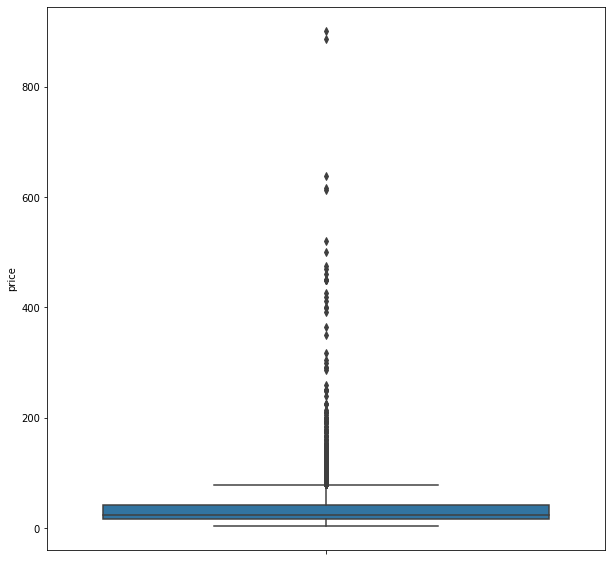

In [15]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=df, y="price", orient="v")

<AxesSubplot:xlabel='price', ylabel='Count'>

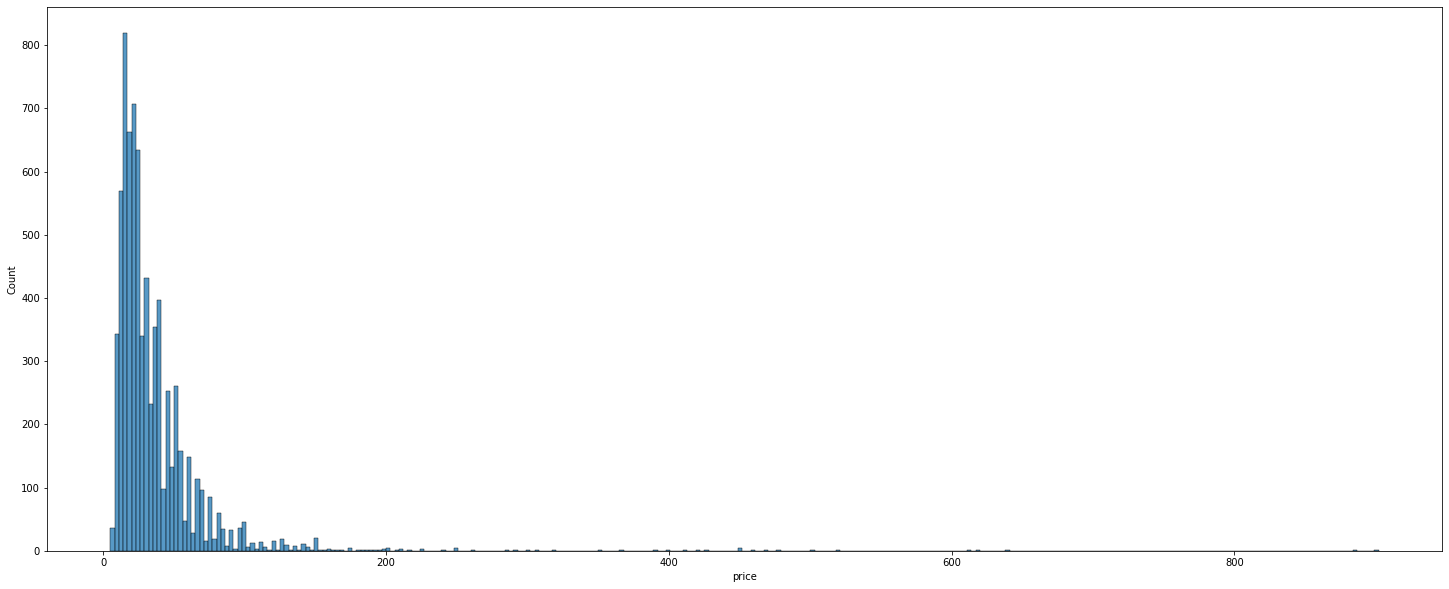

In [16]:
plt.figure(figsize=(25, 10))
sns.histplot(data=df, x="price", binwidth = 3)

Both the boxplot and the histogram of the price, show that it has a distribution skewed closed to 0, with some very expensive wines as outliers.

We want to check how price and the score given to the wine are correlated.
The price is limited to 100 in order to exclude outliers from the visualization.

The scatterplot and the pearson correlation coefficient shows some correlation, so we can expect the price to be a good predictor for the points assigned to the wine. 

,points,price
points,1.000000,0.447162
price,0.447162,1.000000


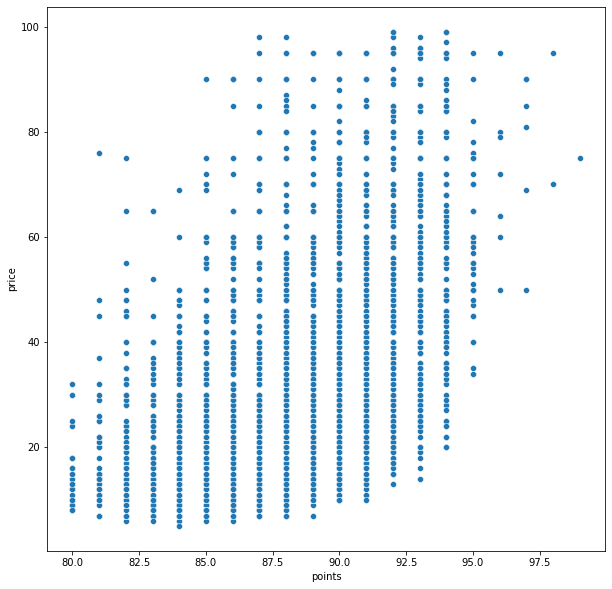

In [17]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df[df["price"]<100], x="points", y="price")
df[["points", "price"]].corr(method="pearson")

<AxesSubplot:xlabel='year', ylabel='Count'>

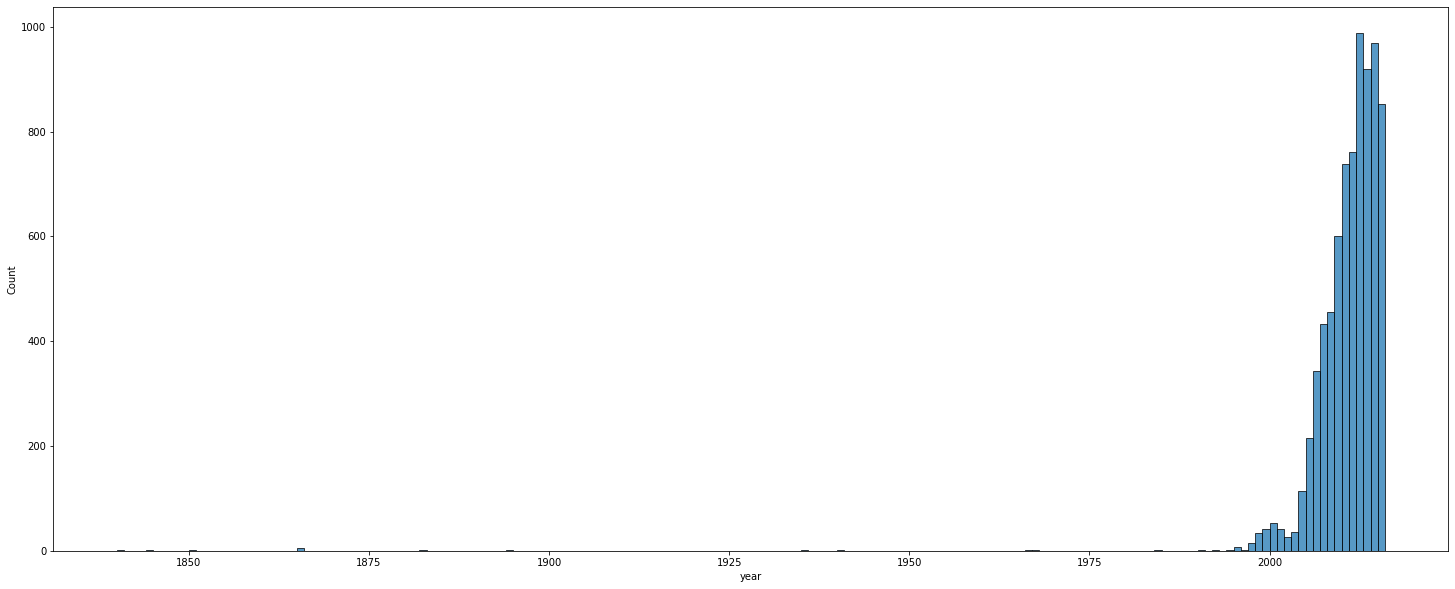

In [18]:
plt.figure(figsize=(25, 10))
sns.histplot(data=df, x="year", binwidth = 1)

The other only numerical variable is year, for which we also check the correlation and scatterplot.
The year is above 1975 in order to exclude outliers from the visualization.

This time the correlation is almost non-existent, so we don't expect this variable alone to have a lot of predictive power over the score of a wine.

,points,year
points,1.000000,0.025313
year,0.025313,1.000000


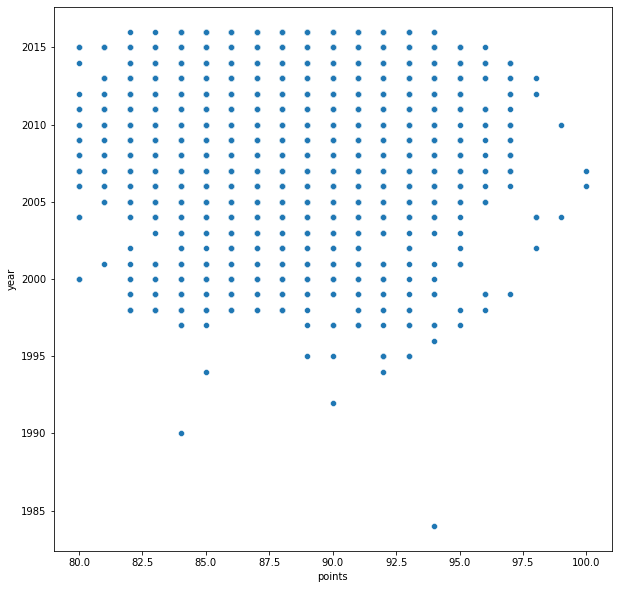

In [19]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df[df["year"]>1975], x="points", y="year")
df[["points", "year"]].corr(method="pearson")

<AxesSubplot:ylabel='year'>

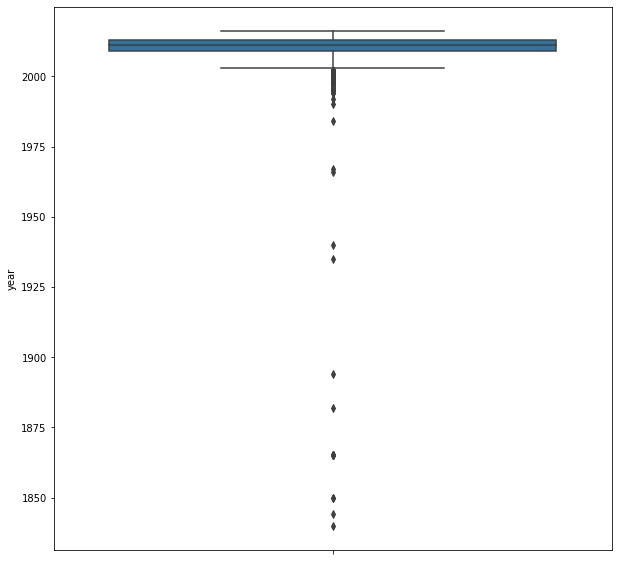

In [20]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=df, y="year", orient="v")

Very old wines tend to be very expensive. Hence we tried to find correlation between the columns `price` and `year`, but both the scatterplot and the correlation coefficient disprove this hypothesis.

,price,year
price,1.000000,-0.120519
year,-0.120519,1.000000


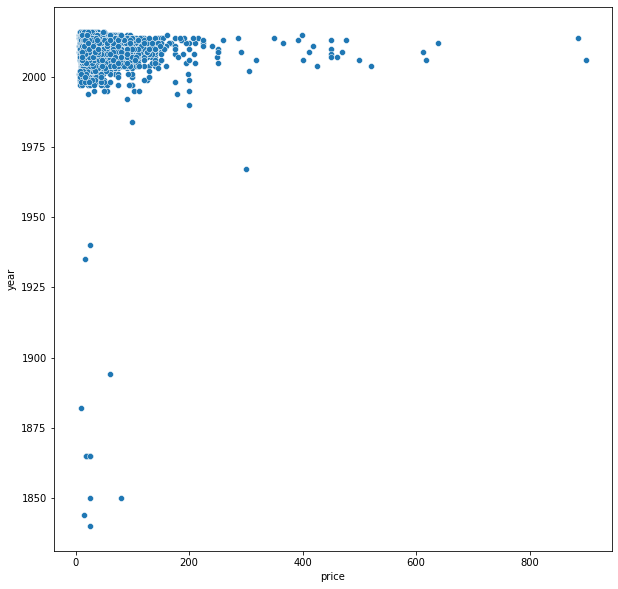

In [21]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x="price", y="year")
df[["price", "year"]].corr(method="spearman")

We fill the empty values for numerical columns with the median, so that outliers do not impact too much on the assigned value.

We notice that `region_2` is present only for US wines. Hence we populate the empty values with the string `not_US`

In [22]:
df["year"] = df["year"].fillna(df["year"].median())
df["price"] = df["price"].fillna(df["price"].median())
df['region_2'] = df['region_2'].fillna("not_US")
df['region_1'] = df['region_1'].fillna("unknown")
df['taster_name'] = df['taster_name'].fillna("unknown")
df['taster_twitter_handle'] = df['taster_twitter_handle'].fillna("missing")

Since the description column has been modeled, we can drop it. We also drop the title, which we used to extract the year, and designation, which has high cardinality, high number of empty values.

In [23]:
df = df.drop(columns=['description', 'designation', 'title', 'winery'])

In [24]:
object_columns = df.select_dtypes(include="object").columns
for column in object_columns:
    print(f"Variable '{column}' has cardinality {df[column].nunique()}")

Variable 'country' has cardinality 35
Variable 'province' has cardinality 231
Variable 'region_1' has cardinality 686
Variable 'region_2' has cardinality 18
Variable 'taster_name' has cardinality 19
Variable 'taster_twitter_handle' has cardinality 3
Variable 'variety' has cardinality 300


The categorical variables are encoded into numbers through Ordinal encoder. Although our categorical variables do not have an intrinsic order, this method makes the computation faster, and it should still return good performances.

In [25]:
# Create object for binary encoding

cols_to_remove = set()  # {'region_2', 'country', 'taster_twitter_handle'}
df = df.drop(columns=cols_to_remove)

cols_to_encode={'country', 'province', 'region_1',
                'region_2', 'taster_name', 'taster_twitter_handle', 'variety'}-cols_to_remove

encoder= ce.OrdinalEncoder(cols=cols_to_encode,return_df=True)
# encoder= ce.OneHotEncoder(cols=cols_to_encode,return_df=True, use_cat_names=True)

#Fit and Transform Data
df = encoder.fit_transform(df)

In [26]:
df.head()

,country,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,variety,year,...,desc_texture,desc_toast,desc_tobacco,desc_touch,desc_vanilla,desc_vineyard,desc_white,desc_wine,desc_wood,desc_years
0,1,86,26.0,1,1,1,1,1,1,2011.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.147904,0.0,0.0
1,1,88,18.0,2,2,2,2,2,2,2011.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.162943,0.0,0.0
2,1,87,32.0,3,3,3,3,1,3,2010.0,...,0.0,0.491836,0.0,0.0,0.000000,0.0,0.0,0.203598,0.0,0.0
3,2,94,75.0,4,4,1,4,2,4,2010.0,...,0.0,0.000000,0.0,0.0,0.313446,0.0,0.0,0.000000,0.0,0.0
4,2,87,25.0,5,5,1,3,1,3,2008.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


<AxesSubplot:xlabel='points', ylabel='Count'>

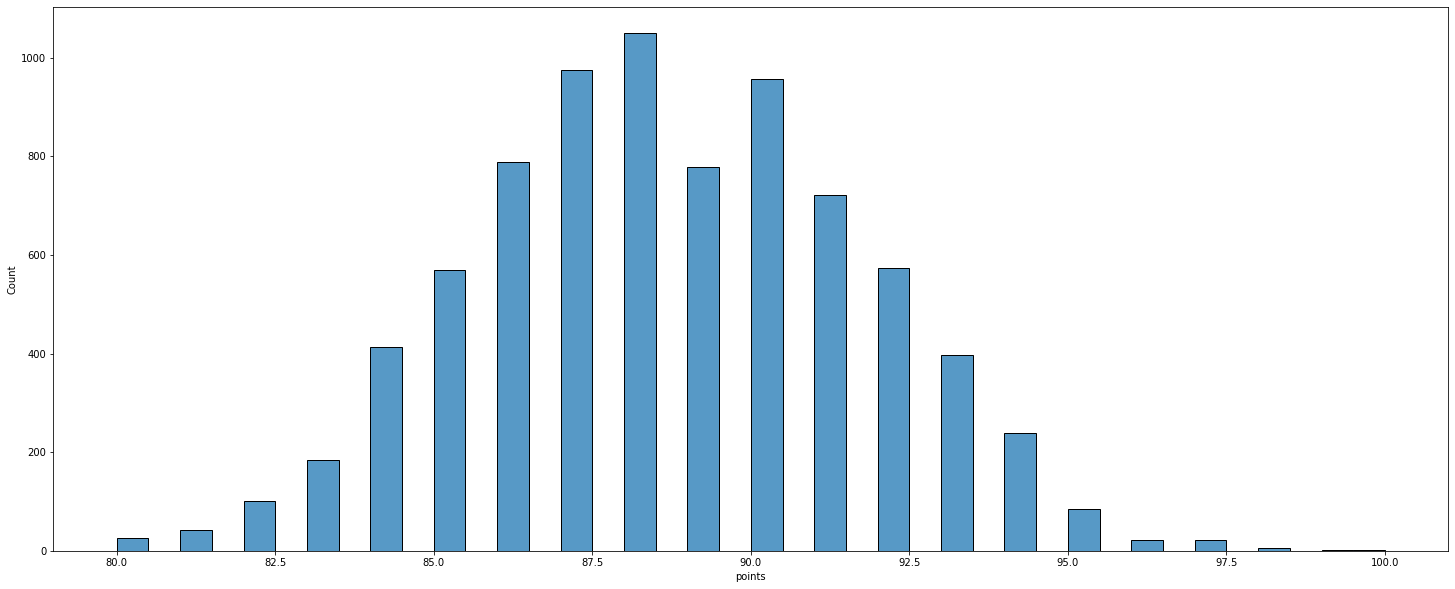

In [27]:
plt.figure(figsize=(25, 10))
sns.histplot(data=df, x="points")

We finally note how the score that we want to predict follows nicely the normal distribution, which we can use later to define a baseline.

## Train-Validation split

Data is split into train and validation sets, where the first one is used to teach the candidate models how to rate wine, and the second one is used to check how well each model learned the task. We chose a 85/15 split.

Stratified split allows to have (approximately) a proportional number of reviews in both splits, so that the target variable distribution between the train and validation sets is as similar as possible.

In [28]:
train_x, val_x, train_y, val_y = train_test_split(df, df[['points']], test_size=0.15,
                                     random_state=42,
                                     stratify=df[['points']])
train_x = train_x.drop(columns=['points'])
val_x = val_x.drop(columns=['points'])

## Model training

In [38]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from xgboost import XGBRegressor, plot_importance
from tempfile import NamedTemporaryFile
from sklearn.model_selection import GridSearchCV
from time import time
import joblib

The problem at hand is treated as a regression problem, since we are predicting a number. Additionally, this number number comes from a distribution close to a normal distribution.

In order to measure how well the trained model is performing, mean squared error metric has been chosen. The nice property about this metric, is that it assumes the (squared) unit of measure of the variable we are measuring, so that we can immediately quantify how far are the predictions of the model from reality.

Fitting the rating score to a normal distribution, we can get the mean and variance. We can use them to draw randomly from the fitted distribution to see how that would work as a baseline for our problem.

In [30]:
mean, var  = scipy.stats.distributions.norm.fit(train_y)
print(f"Mean of normal distribution of wine scores is {mean}, variance is {var}")
pred_val_y = [np.random.normal(loc=mean, scale=var) for _ in range(len(val_x))]
print(f"Baseline: random sampling from fitted normal distribution. MSE: {mean_squared_error(val_y, pred_val_y):.5f}")

Mean of normal distribution of wine scores is 88.45902366863905, variance is 3.0362370035047705
Baseline: random sampling from fitted normal distribution. MSE: 17.84855


Another way to get a baseline, is to assign as points in every prediction the mean (or the median) of the points.

In [31]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(train_x, train_y)
pred_val_y = dummy_regr.predict(val_x)
print(f"Baseline: mean of scores assigned to each value. MSE: {mean_squared_error(val_y, pred_val_y):.5f}")
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(train_x, train_y)
pred_val_y = dummy_regr.predict(val_x)
print(f"Baseline: median of scores assigned to each value. MSE: {mean_squared_error(val_y, pred_val_y):.5f}")

Baseline: mean of scores assigned to each value. MSE: 9.15223
Baseline: median of scores assigned to each value. MSE: 9.36630


The best baseline we got is obtained by assigning the mean for every prediction.

We want to improve on that value, by testing various regression algorithms. Explainability of the models used must be kept into consideration, in order to be able to explain the client if the model is suited for his endeavour.

A range of standard and easy to interpret regression algorithms is tested, with default parameters, in order to quickly see which are the most promising to solve our problem:

In [32]:
regression_models = [LinearRegression, XGBRegressor, SVR, RandomForestRegressor, DecisionTreeRegressor, ExtraTreeRegressor]
for model_class in regression_models:
    model = model_class()
    model.fit(train_x, train_y.values.ravel())
    pred_val_y = model.predict(val_x)
    print(f"For model {model_class} with default parameters, mean squared error is {mean_squared_error(val_y, pred_val_y):.5f}")

For model <class 'sklearn.linear_model._base.LinearRegression'> with default parameters, mean squared error is 5.80884


/home/alberto/.local/share/virtualenvs/code-challenge-2020-VvJGR1c4/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


For model <class 'xgboost.sklearn.XGBRegressor'> with default parameters, mean squared error is 4.84527
For model <class 'sklearn.svm._classes.SVR'> with default parameters, mean squared error is 7.73080
For model <class 'sklearn.ensemble._forest.RandomForestRegressor'> with default parameters, mean squared error is 4.90816
For model <class 'sklearn.tree._classes.DecisionTreeRegressor'> with default parameters, mean squared error is 9.35289
For model <class 'sklearn.tree._classes.ExtraTreeRegressor'> with default parameters, mean squared error is 9.77033


Linear Regression and Random Forest Regression are the ones that perform the best on our dataset.
For both of them, we plot the importance of their features, to see what are the one with the most predictive power.

We also see how long it takes to train the model, to have an idea on how much hyperparameter tuning we can do in the same timespan.

In [33]:
started = time()

model = XGBRegressor()
model.fit(train_x, train_y.values.ravel())

finished = time()
pred_val_y = model.predict(val_x)

print(f"For model XGBRegressor, mean squared error is {mean_squared_error(val_y, pred_val_y)} (fitted in {finished-started} seconds)")

For model XGBRegressor, mean squared error is 4.845271169868669 (fitted in 1.093679428100586 seconds)


/home/alberto/.local/share/virtualenvs/code-challenge-2020-VvJGR1c4/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


<Figure size 1800x3600 with 0 Axes>

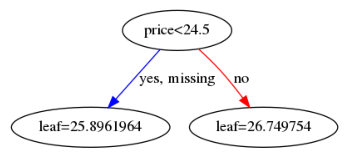

In [34]:
from xgboost import plot_tree
plt.figure(figsize=(25, 50))
plot_tree(model, num_trees=0)

plt.show()

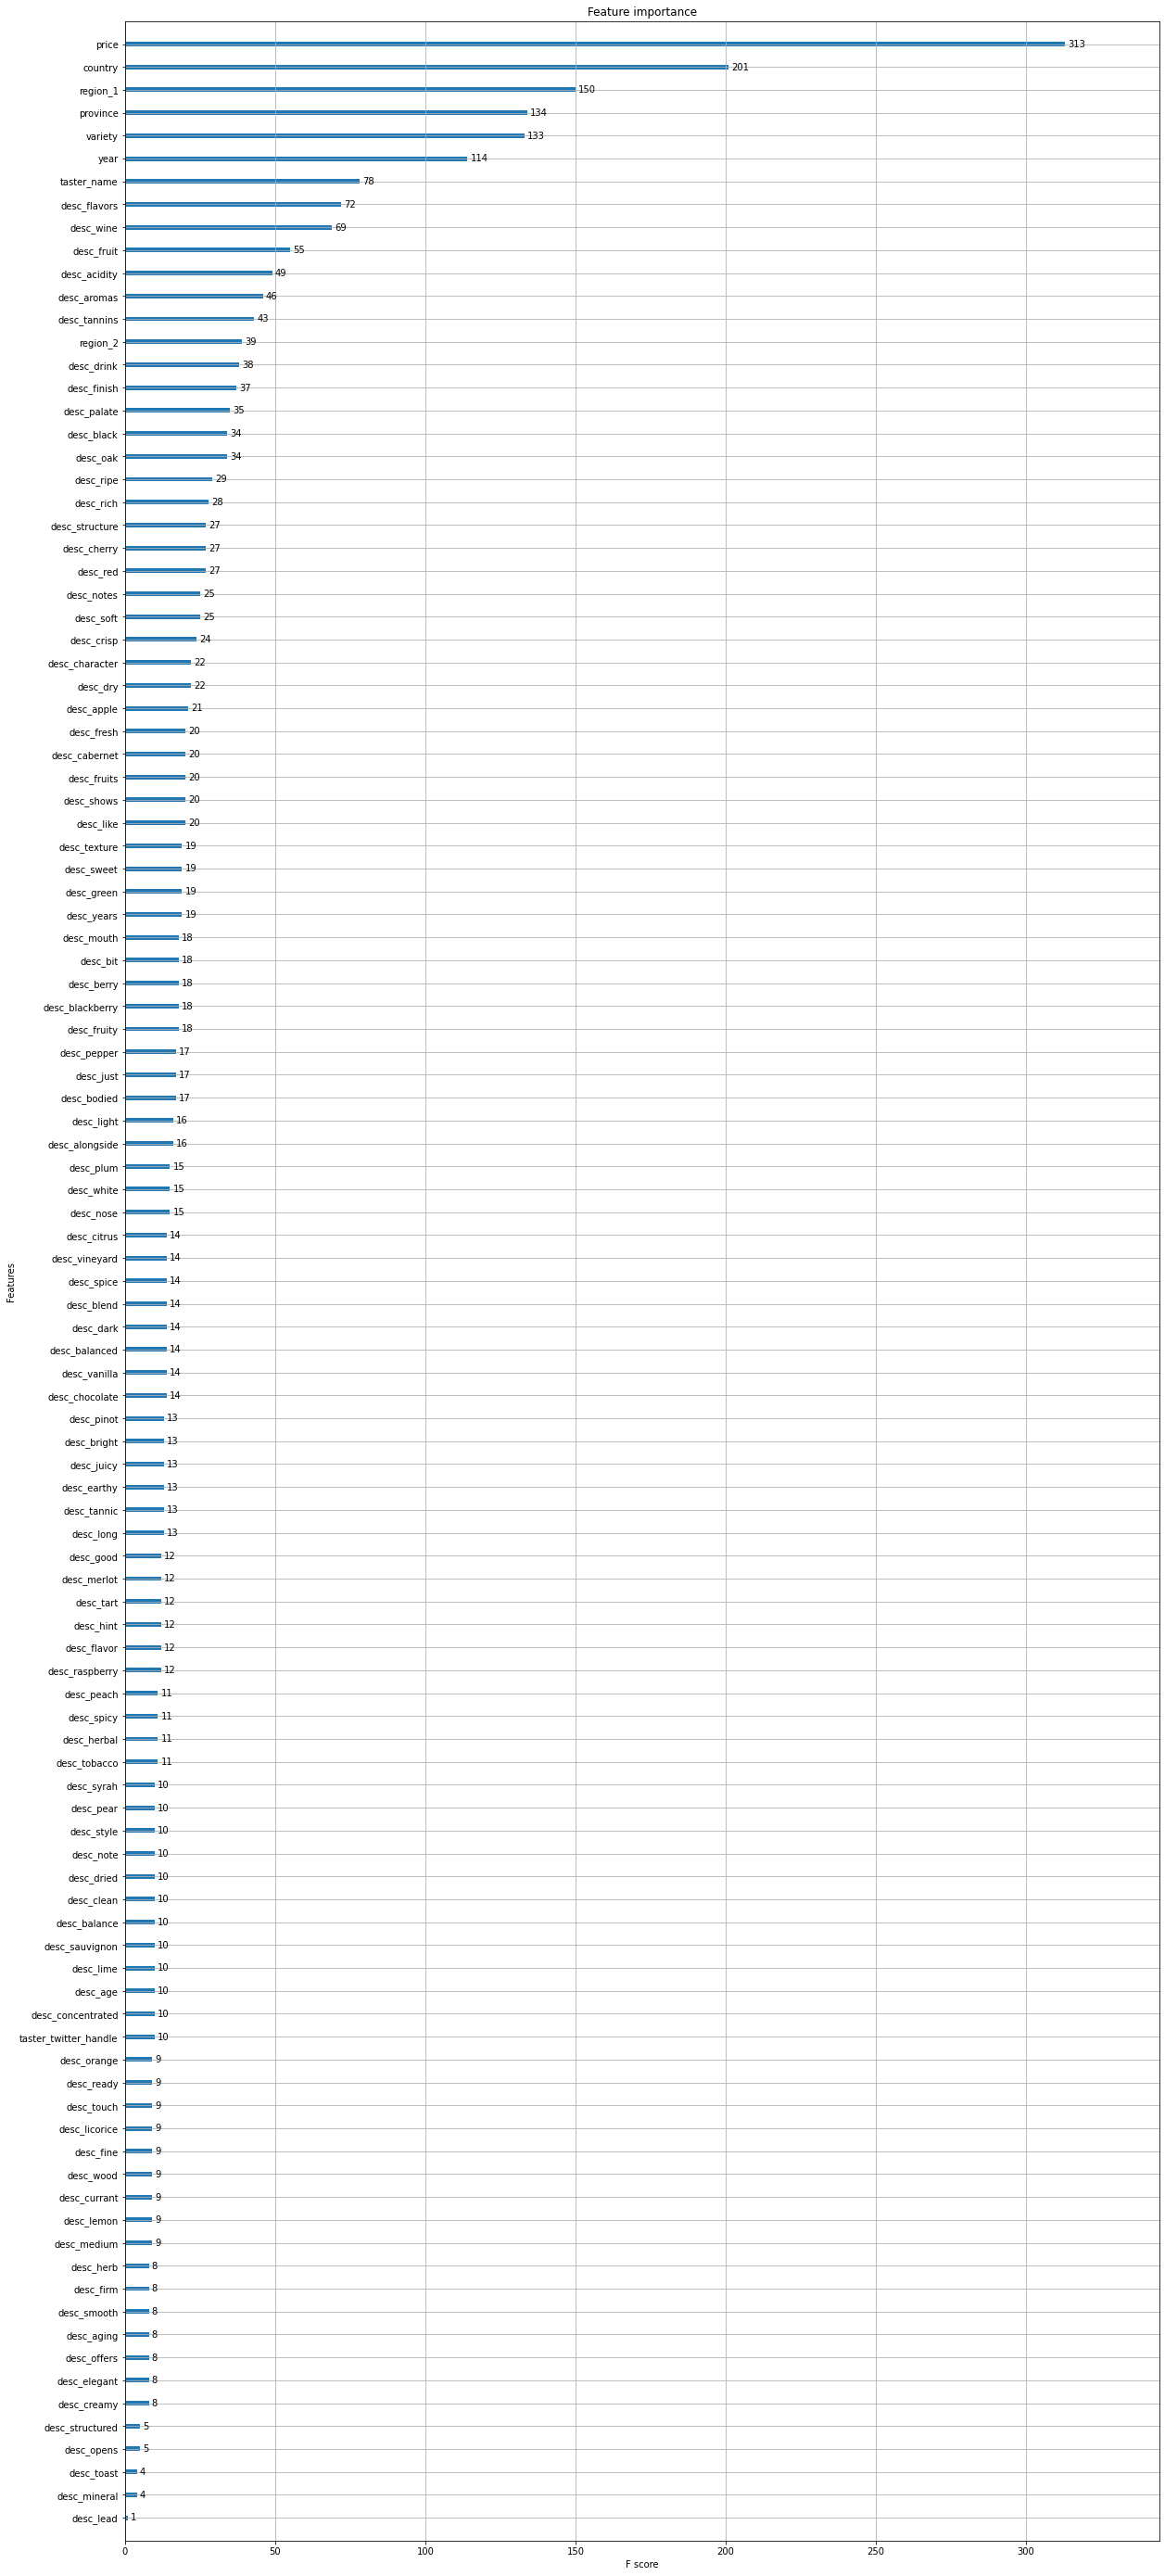

In [40]:
with NamedTemporaryFile(suffix='.tsv', mode='w+') as open_tsv:
    for i, column_name in enumerate(train_x.columns):
        open_tsv.write(f"{i}\t{column_name}\tq\n")
    open_tsv.flush()
    open_tsv.seek(0)

    fig, ax = plt.subplots(figsize=(20, 50))
    plot_importance(model,ax=ax, fmap=open_tsv.name)

    plt.show()

In [41]:

started = time()

model = RandomForestRegressor()
model.fit(train_x, train_y.values.ravel())

finished = time()
pred_val_y = model.predict(val_x)

print(f"For model RandomForestRegressor, mean squared error is {mean_squared_error(val_y, pred_val_y)} (fitted in {finished-started} seconds)")


For model RandomForestRegressor, mean squared error is 4.875758927074601 (fitted in 12.820031881332397 seconds)


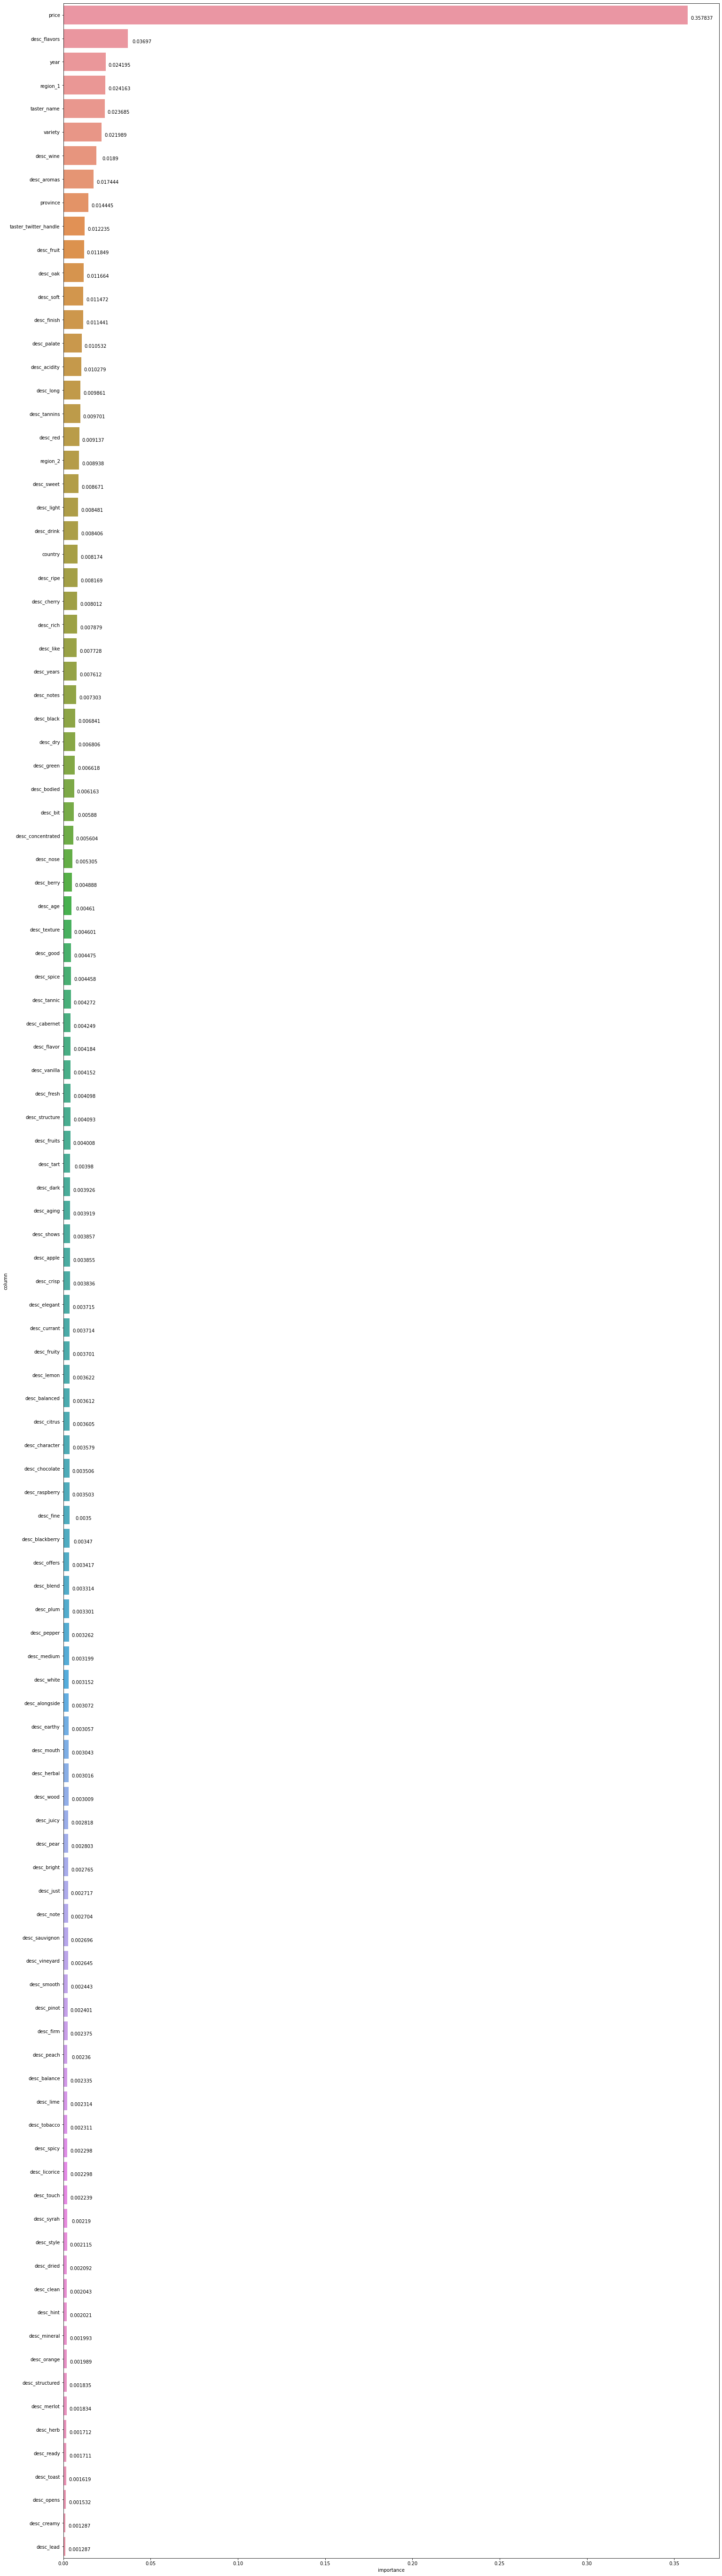

In [42]:
importances = model.feature_importances_
# std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

importance_per_column = []
for f in range(train_x.shape[1]):
    importance_per_column.append([train_x.columns[indices[f]], importances[indices[f]]])
importances_df = pd.DataFrame(importance_per_column, columns=["column", "importance"])

plt.figure(figsize=(25, 100))
gr = sns.barplot(x="importance", y="column", data=importances_df)
for index, row in importances_df.iterrows():
    gr.text(row.importance+0.008, index+0.2, round(row.importance,6), color='black', ha="center")

plt.show()

We see from the above graphs that both model have `price` as the most important variable for predicting the points assigned to the wine. That is little surprise because of the farily strong correlation we discovered during data analysis phase.

The differences are in how the other variables impact how good the model can predict. With XGBoost, the various words extracted from the description have a higher predictive power than with the Random forest model. This is a good thing in scenarios where other variables like `price` is missing, where we expect Random Forest to perform poorly. Also, the XGBoost regressor is way quicker to train, meaning that we can try more configurations during the hyperparameter tuning phase, resulting in possibly a better model.

Hence we choose XGBoost regressor as a model, and proceeded to tune its hyperparameter to get the configuration that trains the model with the lowest mean squared error.

In [43]:
hpt_result = joblib.load('gs_xgbr.pkl')

In [44]:
print(hpt_result)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             pa

In [45]:
print(hpt_result.best_score_)
print(hpt_result.best_params_)

-4.265173278898503
{'colsample_bytree': 0.3, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 12, 'min_child_weight': 7}


Hyperparameter tuning on gridsearch allowed to obtain an additional boost in performance, reaching an even lower MSE.

The parameters used to train the model, are used to train the final model on the full training set (including the validation split that we separated earlier on), and this model will be evaluated agains the hold out (test) set that we kept outside of this analysis.

*Note: The experiment has not been run on this notebook since from some reason the command fit for GridSearchCV had no effect. Also, the execution time was about 4 hours on a 4 cores (8 threads) processor, hence the cell is marked as `raw` so that it is not executed automatically*